<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - ISCTE <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
import quantstats as qs

# High-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [ ]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
data = mu.history(start="2019-01-01", end="2023-09-30")

data.info()
data.tail()

In [ ]:
# Daily close price data for MU
data.Close.plot()

## 2. Calculate returns, expected mean returns and risk

In [ ]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
# rf = (1.02 ** (1 / 360)) - 1

risk_free_rate = 0
sr = (mean_returns - risk_free_rate) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


## 3. Define statistical trading strategy (at least one, maximum 2)

In [ ]:
# Exponential moving average (EMA) strategy
def ema_strategy(data):
    # Define your trading strategy based on the historical data
    # Example: Buy when the 20-day moving average is above the 100-day moving average, sell otherwise
    signals = pd.DataFrame(data)

    # EMA for 10 and 50-day windows
    signals['ema_short'] = signals['Close'].ewm(span = 20, adjust = False).mean()
    signals['ema_long'] = signals['Close'].ewm(span = 100, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1, -1)
    signals['crossover'] = signals['bullish'].diff()

    # Calculate passive and strategy's returns
    signals['returns'] = np.log(signals['Close'] / signals['Close'].shift(1))
    signals['strategy'] = signals['bullish'].shift(1) * signals['returns']
    
    return signals

In [ ]:
# Initiate strategy
ema = ema_strategy(data)

# Plot exponential moving averages for our strategy
# fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ema['Close'], label='Closing price', color='grey', linestyle=':', linewidth=0.5)
ax.plot(ema['ema_short'], label='20-day EMA', color='#014f86')
ax.plot(ema.index[-1], ema['ema_short'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#014f86')
ax.plot(ema['ema_long'], label='100-day EMA', color='#DC0000')
ax.plot(ema.index[-1], ema['ema_long'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#DC0000')

# Plot crossovers
idx = np.argwhere(ema['crossover']).flatten()
ax.plot(ema['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')

# Add Legend and Labels
ax.legend(loc='best')

# Prettify

## Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

## Reformat y-axis
ax.set_ylabel('Price in USD')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## Remove the spines
ax.spines[['top','right','bottom']].set_visible(False)

## Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
# Add in title and subtitle
ax.set_title(label="Comparing MU's closing price from 2019 to 2023 with two EMA")
## Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Show the plot
plt.show()


In [ ]:
# Plot our strategy's positions
ema['bullish'].plot(ylim=[-1.1, 1.1],
title='Strategy Positioning',
figsize=(10, 6))

In [ ]:
# Plot our strategy's returns compared to MU's stock performance
ema[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                         title="Gross performance of MU compared to the EMA-based strategy")

ema[['returns', 'strategy']].sum() * 252

## 4. Use at least one reinforcement learning algorithm for trading the assets (Q-learning, deep Q-learning)

In [109]:
# create environment with specific parameters
mu = yf.Ticker("MU")
data = mu.history(start="2019-01-01", end="2023-09-30")

env = gym.make('forex-v0',
    df = data,
    window_size=5,
    # frame_bound=(50, 100),
    unit_side='right'
)

In [110]:
# print information
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

env information:
> shape: (5, 2)
> df.shape: (1195, 7)
> prices.shape: (1176,)
> signal_features.shape: (1176, 2)
> max_possible_profit: 355528.2456644322


info: {'total_reward': -449166.83197021484, 'total_profit': 0.9436549663531043, 'position': <Positions.Long: 1>}


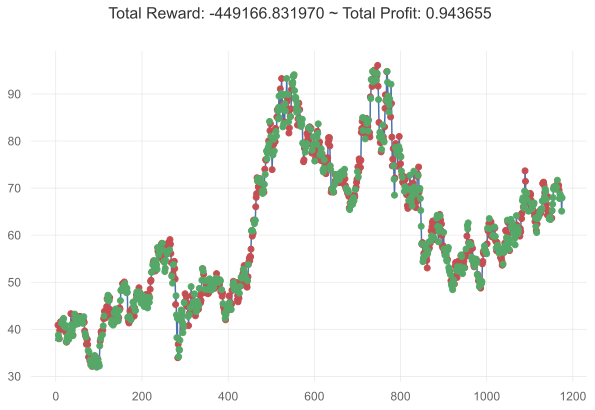

In [111]:
observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

## 5. Compare Statistical method to RL strategy

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-01-04   2019-01-04
End Period                 2023-08-24   2023-08-24
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       25.0%

Cumulative Return          -67.82%      -5.63%
CAGR﹪                     -15.53%      -0.86%

Sharpe                     -0.29        0.13
Prob. Sharpe Ratio         26.53%       60.96%
Smart Sharpe               -0.29        0.13
Sortino                    -0.4         0.18
Smart Sortino              -0.4         0.18
Sortino/√2                 -0.29        0.13
Smart Sortino/√2           -0.29        0.13
Omega                      1.05         1.05

Max Drawdown               -74.94%      -58.01%
Longest DD Days            1617         931
Volatility (ann.)          46.59%       32.65%
R^2                        0.0          0.0
Information Ratio          0.02         0.02
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-02-05,2022-11-21,2023-08-24,931,-58.010749,-57.095070
2,2020-01-27,2020-02-07,2020-05-11,106,-31.659391,-19.051755
3,2019-01-23,2019-04-25,2019-05-23,121,-22.341473,-20.649917
4,2019-08-15,2019-09-13,2019-11-29,107,-17.653970,-13.978647
5,2020-05-18,2020-07-17,2020-12-07,204,-16.160099,-14.247387


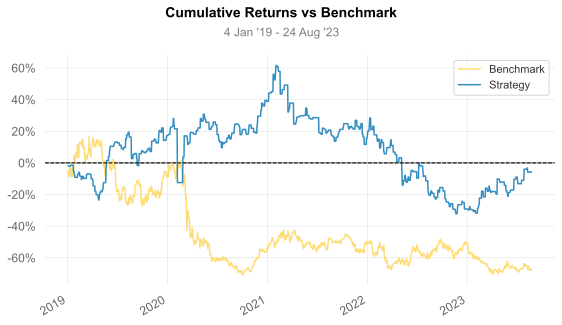

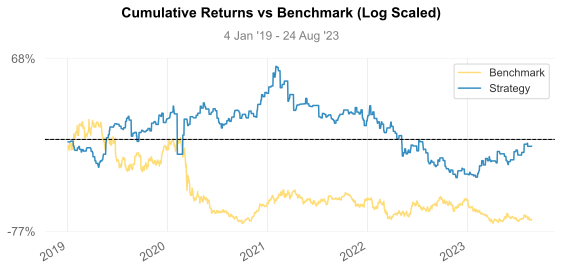

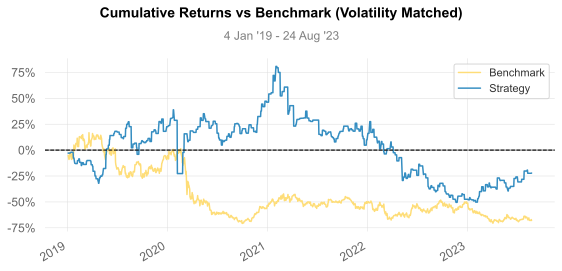

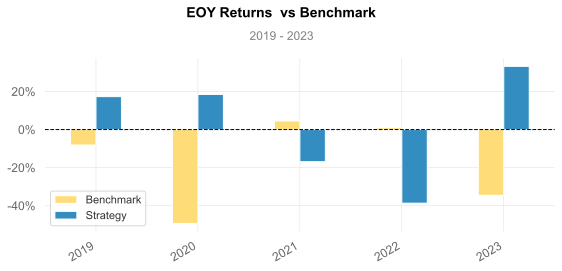

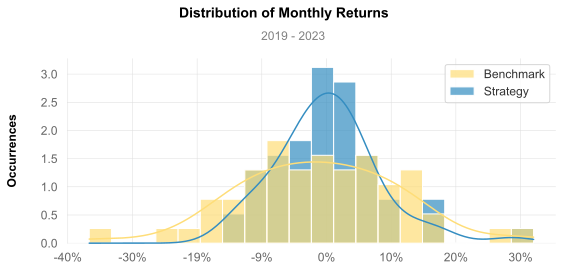

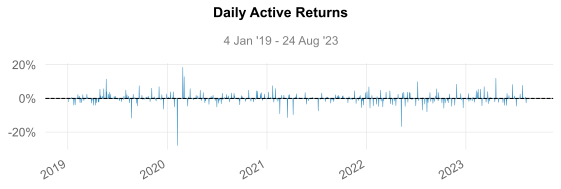

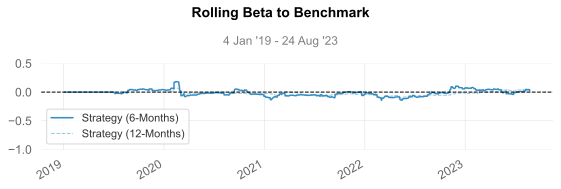

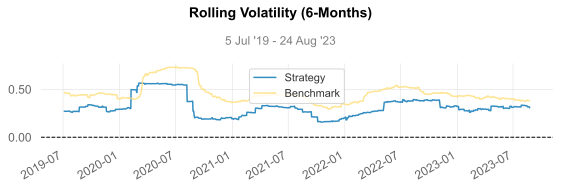

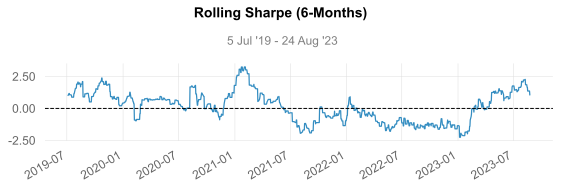

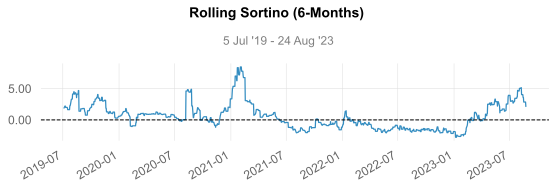

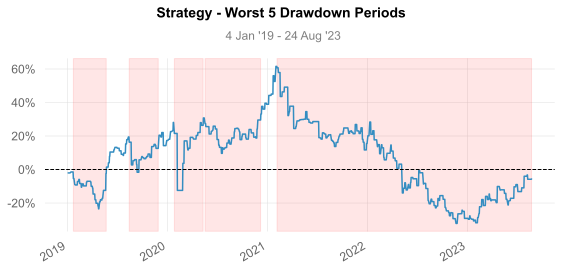

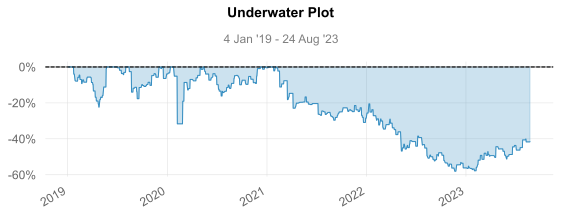

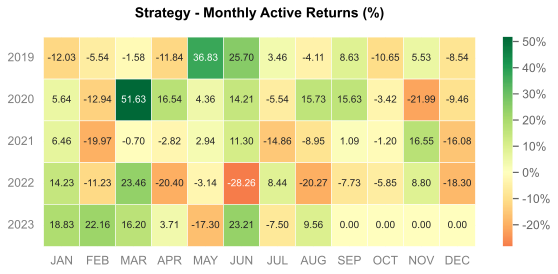

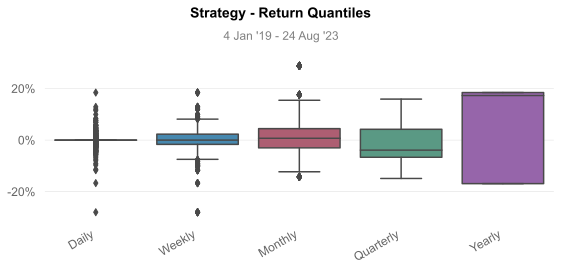

In [125]:
# Comparison metrics and plots between EMA and RL strategies
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=data.index[0:1170])
rl_returns = net_worth.pct_change().iloc[1:]

ema_series = pd.Series(ema['strategy'], index=data.index[0:1170])

rl_returns = rl_returns.tz_localize(None)
ema_returns = ema_series.tz_localize(None)

qs.reports.full(rl_returns, ema_returns)

## 7. Fine-tune your algorithms

In [ ]:
'''Insert code here'''

## 8. Compare and interpret the results

In [ ]:
'''Insert code here'''